# Classification des sentiments dans les critiques de films avec Textblob et Vader Sentiment

In [1]:


import numpy as np # Algèbre linéaire
import pandas as pd # Pretraitement des données

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input\stanford-sentiment-treebank-v2-sst2\SST2-Data\SST2-Data\trainDevTestTrees_PTB\trees\dev.txt
/kaggle/input\stanford-sentiment-treebank-v2-sst2\SST2-Data\SST2-Data\trainDevTestTrees_PTB\trees\test.txt
/kaggle/input\stanford-sentiment-treebank-v2-sst2\SST2-Data\SST2-Data\trainDevTestTrees_PTB\trees\train.txt


In [2]:
!pip install pytreebank

#### Pytreebank : Utilisé pour charger le jeu de données SST

## importation des bibliothèques

In [3]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
from sklearn.metrics import f1_score,accuracy_score
import matplotlib.pyplot as plt
import pytreebank
import os,sys

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Lecture et formatage du jeu de données

In [4]:
data = pytreebank.load_sst("/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/trainDevTestTrees_PTB/trees/")

In [5]:
for item in data['train']:
    print(item.to_labeled_lines()[0][0],item.to_labeled_lines()[0][1])
    break
    

3 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [6]:

out_path = os.path.join("C:/Users/pc/OneDrive/Documents/Cours_IUT/Machine learning/sst_{}.txt")# new file format

#### formatage des données à partir du format {(étiquette,phrase) => étiquette phrase}

In [7]:
for cat in ['train','test','dev']:
    with open(out_path.format(cat),"w", encoding='utf-8') as file:
        for item in data[cat]:
            file.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] +1,
                item.to_labeled_lines()[0][1]
            ))
    
    print("done with {}".format(file))

done with <_io.TextIOWrapper name='C:/Users/pc/OneDrive/Documents/Cours_IUT/Machine learning/sst_train.txt' mode='w' encoding='utf-8'>
done with <_io.TextIOWrapper name='C:/Users/pc/OneDrive/Documents/Cours_IUT/Machine learning/sst_test.txt' mode='w' encoding='utf-8'>
done with <_io.TextIOWrapper name='C:/Users/pc/OneDrive/Documents/Cours_IUT/Machine learning/sst_dev.txt' mode='w' encoding='utf-8'>


In [8]:
len(data['train'])

8544

In [9]:
# now you can read the formatted files from pandas easily
train = pd.read_csv("C:/Users/pc/OneDrive/Documents/Cours_IUT/Machine learning/sst_train.txt",sep="\t",header=None,names=['label','text'])
train['label'] = train['label'].str.replace("__label__","")
train['label'] = train['label'].astype(int).astype("category")

In [10]:
train.head()

,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


In [11]:
train['len'] = train['text'].str.len()

In [12]:
train.head()

,label,text,len
0,4,The Rock is destined to be the 21st Century 's...,181
1,5,The gorgeously elaborate continuation of `` Th...,226
2,4,Singer/composer Bryan Adams contributes a slew...,208
3,3,You 'd think by now America would have had eno...,100
4,4,Yet the act is still charming here .,36


In [13]:
train["label"].describe()

count     8544
unique       5
top          4
freq      2322
Name: label, dtype: int64

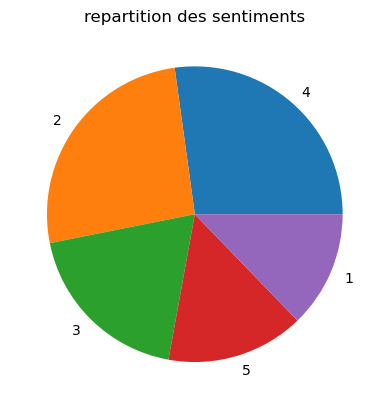

In [14]:
labels_count = train['label'].value_counts()
values = labels_count.values.tolist()
labels = labels_count.index.tolist()

plt.pie(values, labels = labels)

plt.title("repartition des sentiments")
plt.show()

In [32]:
test = pd.read_csv("C:/Users/pc/OneDrive/Documents/Cours_IUT/Machine learning/sst_test.txt",sep="\t",header=None,names=['label','text'])
test['label'] = test['label'].str.replace("__label__","")
test['label'] = test['label'].astype(int).astype("category")

In [16]:
test.head()

,label,text
0,3,Effective but too-tepid biopic
1,4,If you sometimes like to go to the movies to h...
2,5,"Emerges as something rare , an issue movie tha..."
3,3,The film provides some great insight into the ...
4,5,Offers that rare combination of entertainment ...


## Pretraitement des données

In [37]:


# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Liste des mots vides (stopwords) en anglais (vous pouvez changer de langue si nécessaire)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Convertir le texte en minuscules
    text = text.lower()

    # 2. Enlever les balises HTML si elles existent
    text = re.sub(r'<.*?>', '', text)

    # 3. Enlever les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 4. Enlever les mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # 5. Enlever les caractères spéciaux, les chiffres et les ponctuations
    text = re.sub(r'[^a-z\s]', '', text)

    # 6. Tokenization: Diviser le texte en mots
    tokens = word_tokenize(text)

    # 7. Enlever les stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 8. (Optionnel) Stemming ou Lemmatization (réduire les mots à leur racine)
    # Vous pouvez utiliser nltk.stem.PorterStemmer() pour le stemming ou
    # nltk.stem.WordNetLemmatizer() pour la lemmatisation.
    stemmer = nltk.stem.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # 9. Reconstruire le texte
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
train["text_nettoyé"] = train["text"].apply(preprocess_text)
train.head()

,label,text,len,text_nettoyé,textblob_score
0,4,The Rock is destined to be the 21st Century 's...,181,rock destin st centuri new conan go make splas...,0.318182
1,5,The gorgeously elaborate continuation of `` Th...,226,gorgeous elabor continu lord ring trilog huge ...,0.550000
2,4,Singer/composer Bryan Adams contributes a slew...,208,singercompos bryan adam contribut slew song po...,0.200000
3,3,You 'd think by now America would have had eno...,100,think america would enough plucki british ecce...,0.000000
4,4,Yet the act is still charming here .,36,yet act still charm,0.000000


In [39]:
test["text_nettoyé"] = test["text"].apply(preprocess_text)
test.head()

,label,text,text_nettoyé
0,3,Effective but too-tepid biopic,effect tootepid biopic
1,4,If you sometimes like to go to the movies to h...,sometim like go movi fun wasabi good place start
2,5,"Emerges as something rare , an issue movie tha...",emerg someth rare issu movi honest keenli obse...
3,3,The film provides some great insight into the ...,film provid great insight neurot mindset comic...
4,5,Offers that rare combination of entertainment ...,offer rare combin entertain educ


## Test des différents modèles

In [40]:
def f1_acc(df,pred_column):
    f1_macro  = f1_score(df['label'],df[pred_column],average='macro')
    acc = accuracy_score(df['label'],df[pred_column])*100
    print("F1 Score : {} \n Accuracy : {}".format(f1_macro,acc))

## Utilisation de TextBlob

In [41]:
def textblob_score(sentence):
    return TextBlob(sentence).sentiment.polarity

In [42]:
test['textblob_score'] =  test['text_nettoyé'].apply(textblob_score)
test.head()

,label,text,text_nettoyé,textblob_score
0,3,Effective but too-tepid biopic,effect tootepid biopic,0.0000
1,4,If you sometimes like to go to the movies to h...,sometim like go movi fun wasabi good place start,0.5000
2,5,"Emerges as something rare , an issue movie tha...",emerg someth rare issu movi honest keenli obse...,0.4500
3,3,The film provides some great insight into the ...,film provid great insight neurot mindset comic...,0.2875
4,5,Offers that rare combination of entertainment ...,offer rare combin entertain educ,0.3000


In [43]:

test['textblob_pred'] = pd.cut(test['textblob_score'],bins=5,labels=[1,2,3,4,5])
test  = test.drop(['textblob_score'],axis=1)

In [44]:
test.head()

,label,text,text_nettoyé,textblob_pred
0,3,Effective but too-tepid biopic,effect tootepid biopic,3
1,4,If you sometimes like to go to the movies to h...,sometim like go movi fun wasabi good place start,4
2,5,"Emerges as something rare , an issue movie tha...",emerg someth rare issu movi honest keenli obse...,4
3,3,The film provides some great insight into the ...,film provid great insight neurot mindset comic...,4
4,5,Offers that rare combination of entertainment ...,offer rare combin entertain educ,4


In [45]:
f1_acc(test,"textblob_pred")

F1 Score : 0.1883719915646152 
 Accuracy : 22.805429864253394


### Utilisation de  Vader Sentiment

In [46]:
vader = SentimentIntensityAnalyzer()

def vader_score(sent,vader):
    return vader.polarity_scores(sent)['compound']

In [47]:
test['vader_score'] =  test['text'].apply(lambda x : vader_score(x,vader))
test.head()

,label,text,text_nettoyé,textblob_pred,vader_score
0,3,Effective but too-tepid biopic,effect tootepid biopic,3,0.2617
1,4,If you sometimes like to go to the movies to h...,sometim like go movi fun wasabi good place start,4,0.8271
2,5,"Emerges as something rare , an issue movie tha...",emerg someth rare issu movi honest keenli obse...,4,0.6592
3,3,The film provides some great insight into the ...,film provid great insight neurot mindset comic...,4,0.5994
4,5,Offers that rare combination of entertainment ...,offer rare combin entertain educ,4,0.4215


In [48]:
test['vader_pred'] = pd.cut(test['vader_score'],bins=5,labels=[1,2,3,4,5])
test = test.drop('vader_score',axis=1)
test.head()

,label,text,text_nettoyé,textblob_pred,vader_pred
0,3,Effective but too-tepid biopic,effect tootepid biopic,3,4
1,4,If you sometimes like to go to the movies to h...,sometim like go movi fun wasabi good place start,4,5
2,5,"Emerges as something rare , an issue movie tha...",emerg someth rare issu movi honest keenli obse...,4,5
3,3,The film provides some great insight into the ...,film provid great insight neurot mindset comic...,4,5
4,5,Offers that rare combination of entertainment ...,offer rare combin entertain educ,4,4


In [49]:
f1_acc(test,"vader_pred")

F1 Score : 0.3136923605939262 
 Accuracy : 31.583710407239817


### Meilleur modèle => Vader Sentiment (a un meilleur score f1)

In [50]:
test['textblob_pred'] = test['textblob_pred'].astype(int)
test['vader_pred'] = test['vader_pred'].astype(int)

<Axes: >

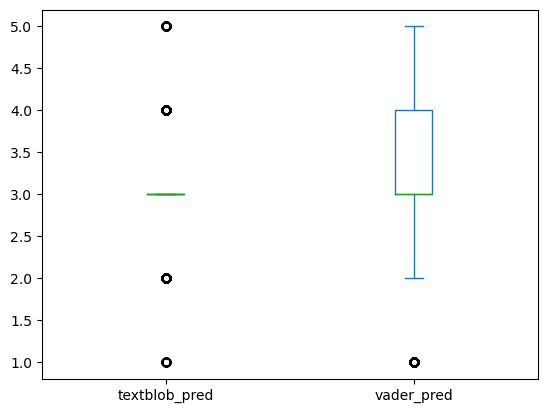

In [51]:
test.plot(x='label',y=['textblob_pred','vader_pred'],kind='box')